In [1]:
import os
import glob
import numpy as np
from scipy import ndimage
from IPython.display import Audio
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
from nnmnkwii.preprocessing.f0 import interp1d
from nnmnkwii.util import apply_delta_windows
import pandas as pd

import pyworld
import pysptk
import nnmnkwii
import matplotlib.pyplot as plt

In [2]:
def collect_features(wav_path, fs, frame_period, order):
  
    x, sr = librosa.load(wav_path, sr = fs)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)

    mgc = pysptk.sp2mc(spectrogram, order=order,
                       alpha=pysptk.util.mcepalpha(fs))


    mgc_delta = apply_delta_windows(mgc, windows)
    
    return mgc, mgc_delta


def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']), label = 'Valid Loss')
    plt.legend()

In [3]:
data_folder = '/home/beiming/Desktop/Parsed_data'
group_name = 'SDTL' # ENF or ENM or SDTL
group_folder = os.path.join(data_folder, group_name)
subject_list = os.listdir(group_folder) 
print(subject_list)

['DN004', 'DN011', 'DN006', 'DN008', 'DN009', 'DN005', 'DN007', 'DN010']


In [4]:
sub_name = 'DN008'

data_sub_folder = os.path.join(group_folder, sub_name)

WAV_path_list = os.path.join(data_sub_folder, '*' + '.wav')
WAV_path_list = glob.glob(WAV_path_list)
WAV_path_list.sort()

EMA_path_list = os.path.join(data_sub_folder, '*' + '.MV8')
EMA_path_list = glob.glob(EMA_path_list)
EMA_path_list.sort()

print(len(EMA_path_list))

264


In [5]:
mgc_dim = 40
lf0_dim = 1
vuv_dim = 1
bap_dim = 1

fs = 16000

frame_period = 5
hop_length = 80
fftlen = 1024
alpha = 0.41

order = 39
frame_period = 5
windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

file_num = len(WAV_path_list)



train_index = [i for j in (range(0, 122), range(132, 254)) for i in j]
valid_index = [i for j in (range(122, 127), range(254, 259)) for i in j]
test_index = [i for j in (range(127, 132), range(259, 264)) for i in j]

print(len(train_index))
print(len(valid_index))
print(len(test_index))

244
10
10


In [6]:
Valid_MV = {}
Valid_WAV = {}

index = 0

for i in valid_index:
  
  MV = np.genfromtxt(EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Valid_MV[index] = MV_delta
  Valid_WAV[index] = WAV_delta
  
  index = index + 1  

/home/beiming/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [7]:
Test_MV = {}
Test_WAV = {}

index = 0

for i in test_index:
  
  MV = np.genfromtxt(EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Test_MV[index] = MV_delta
  Test_WAV[index] = WAV_delta
  
  index = index + 1 

In [8]:
Train_MV = {}
Train_WAV = {}

index = 0

for i in train_index:
  
  MV = np.genfromtxt(EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV[index] = MV_delta
  Train_WAV[index] = WAV_delta
  
  index = index + 1 

In [9]:
Train_MV_block = np.concatenate([Train_MV[x] for x in Train_MV], 0).astype(np.float32)
Train_WAV_block = np.concatenate([Train_WAV[x] for x in Train_WAV], 0)

Valid_MV_block = np.concatenate([Valid_MV[x] for x in Valid_MV], 0).astype(np.float32)
Valid_WAV_block = np.concatenate([Valid_WAV[x] for x in Valid_WAV], 0)

Test_MV_block = np.concatenate([Test_MV[x] for x in Test_MV], 0).astype(np.float32)
Test_WAV_block = np.concatenate([Test_WAV[x] for x in Test_WAV], 0)

In [10]:
print(Train_MV_block.shape)
print(Valid_MV_block.shape)
print(Test_MV_block.shape)

(105506, 24)
(3545, 24)
(3847, 24)


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Found GPU at: /device:GPU:0


In [12]:
def build_model():
    
    model = keras.Sequential([
        layers.Dense(512, activation = tf.nn.relu, input_shape = (Train_MV_block.shape[1],)),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(Train_WAV_block.shape[1])
    ])
    
    optimizer = tf.keras.optimizers.SGD(0.003,momentum=0.9)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])
    
    return model

model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               12800     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 120)               61560     
Total params: 1,124,98

Instructions for updating:
Use tf.cast instead.
 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

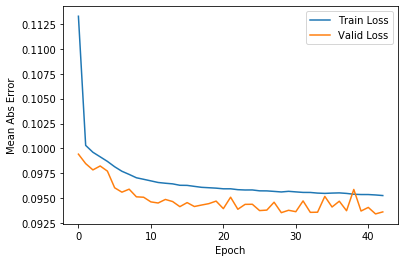

In [13]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print(' ')
        print('.', end = ' ')

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
EPOCHS = 200

history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = EPOCHS, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [early_stop, PrintDot()])
plot_history(history)

In [16]:
test_predictions = model.predict(Test_MV_block)

In [17]:
mgc_head = test_predictions[:, 0:mgc_dim]
mgc_ref = Test_WAV_block[:, 0:mgc_dim]
from nnmnkwii.metrics import melcd

MCD = melcd(mgc_head[:,1:mgc_dim], mgc_ref[:,1:mgc_dim], lengths=None)
print(MCD)

6.473726159017524
